In [1]:
# Necessary imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt


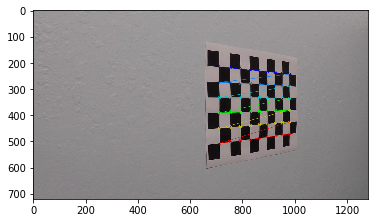

In [2]:
%matplotlib inline

# Find chessboard corners
def FindChessboardCorners(img, nx = 9, ny = 6):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)   
    return ret, corners

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

def EvaluateObjImgPts(camera_images, nx = 9, ny = 6):
    random = np.random.randint(20, size=1)
    random_idx = random[0]
    for idx, fname in enumerate(camera_images):
        img = cv2.imread(fname)
        
        ret, corners = FindChessboardCorners(img)
        
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            if random_idx == idx :
                plt.imshow(img)
    plt.show()  
    
# Make a list of calibration images
camera_images = glob.glob('camera_cal/calibration*.jpg')
EvaluateObjImgPts(camera_images)
    


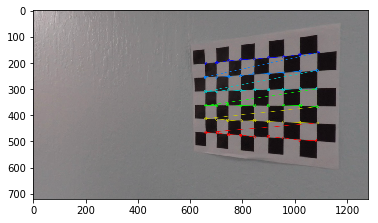

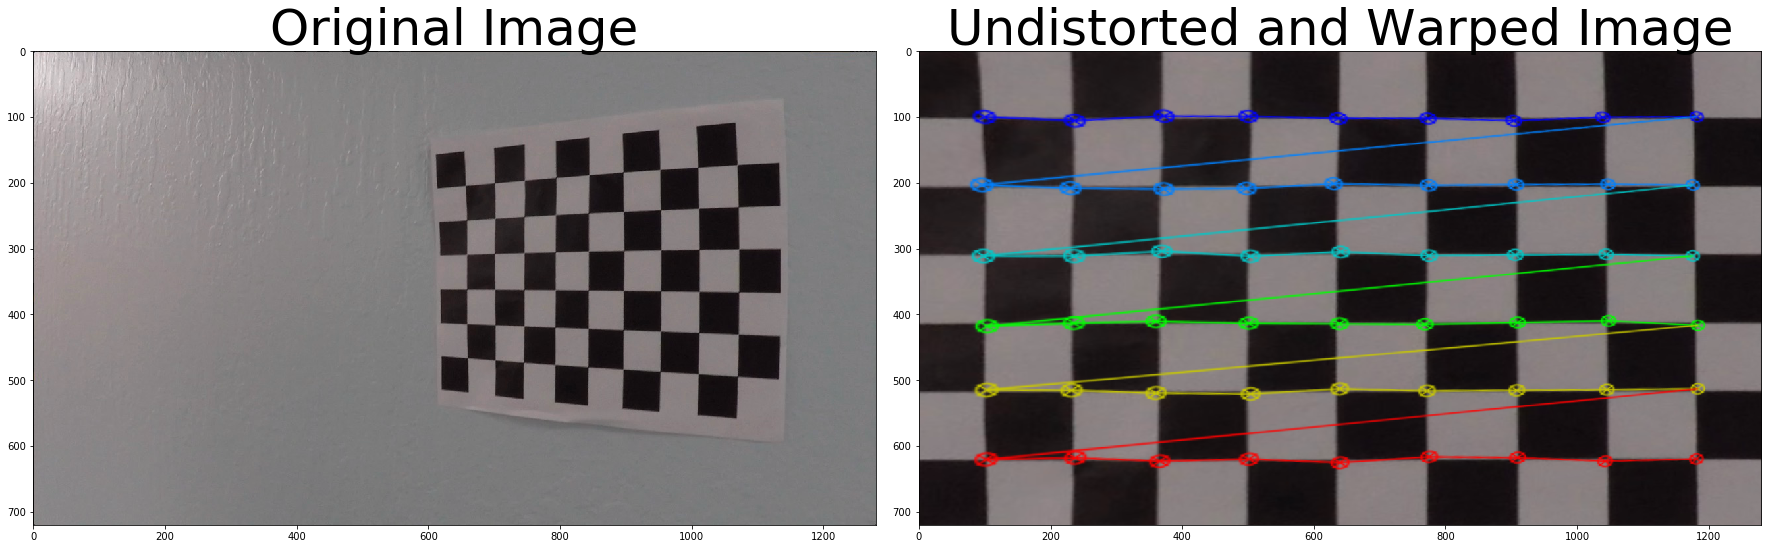

In [3]:
%matplotlib inline

# camera calibration (test undistortion on a test image)
def CalibrateCam(img, nx = 9, ny = 6):
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return ret, mtx, dist, rvecs, tvecs

def UndistortImage(img, mtx, distortion):
    img_size = (img.shape[1], img.shape[0])
    undist_img = cv2.undistort(img, mtx, distortion, None, mtx)    
    return undist_img

# define 4 destination points dst = np.float32([[,],[,],[,],[,]])
def GetTestPerspectiveDst(img):
    offset = 100
    img_size = (img.shape[1], img.shape[0])
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                    [img_size[0]-offset, img_size[1]-offset], 
                    [offset, img_size[1]-offset]])
    return dst
    
def CalibrateUnwarp(img, dst_shape, nx = 9, ny = 6):
    # 2) Convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 3) Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray_img, (nx, ny), None)

    # 4) If corners found: 
    warped = img
    M = []
    if ret == True:
        # a) draw corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)
            
        # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
                         
        #Note: you could pick any four of the detected corners 
        # as long as those four corners define a rectangle
        #One especially smart way to do this would be to use four well-chosen
        # corners that were automatically detected during the undistortion steps
        #We recommend using the automatic detection of corners in your code
        

        # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
        M = cv2.getPerspectiveTransform(src, dst_shape)
        
        # e) use cv2.warpPerspective() to warp your image to a top-down view
        warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))

    return warped, M
    
img = cv2.imread(camera_images[3])
ret, camera_calib, dist, rvecs, tvecs = CalibrateCam(img) 
undistorted_test_image = UndistortImage(img, camera_calib, dist)
dst_shape = GetTestPerspectiveDst(undistorted_test_image)
top_down_test, perspective_M_test = CalibrateUnwarp(undistorted_test_image, dst_shape)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down_test)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

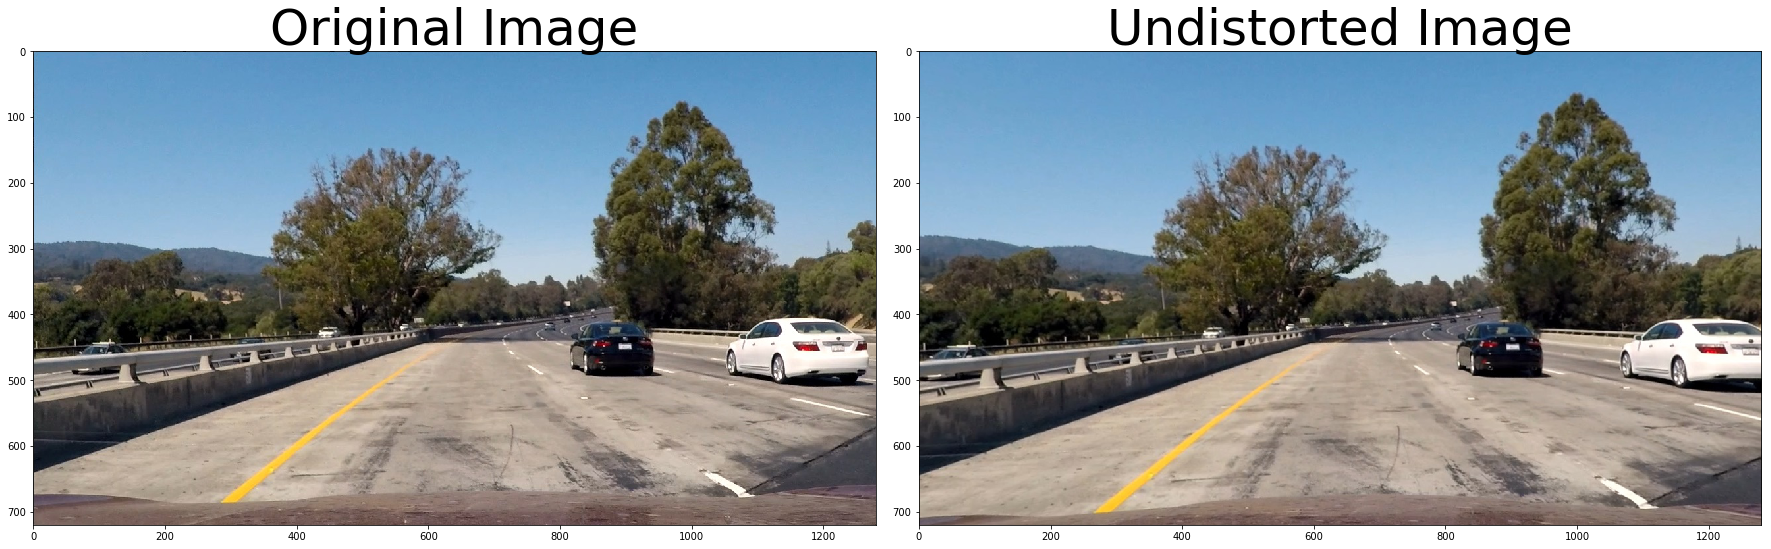

In [4]:
test_images = glob.glob('test_images/*.jpg')

img = cv2.imread(test_images[2])
proc_img = UndistortImage(img, camera_calib, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(cv2.cvtColor(proc_img, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [5]:
# apply threshold and possibly crop non-lane regions

# Edit this function to create your own pipeline.
def Threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    combined = np.zeros_like(s_channel)
    combined[(s_binary == 1) | (sxbinary == 1)] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    # color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    color_binary = np.dstack((combined,combined,combined))
    return color_binary



In [6]:
# Extracts a ROI

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (1,) * channel_count
    else:
        ignore_mask_color = 1
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

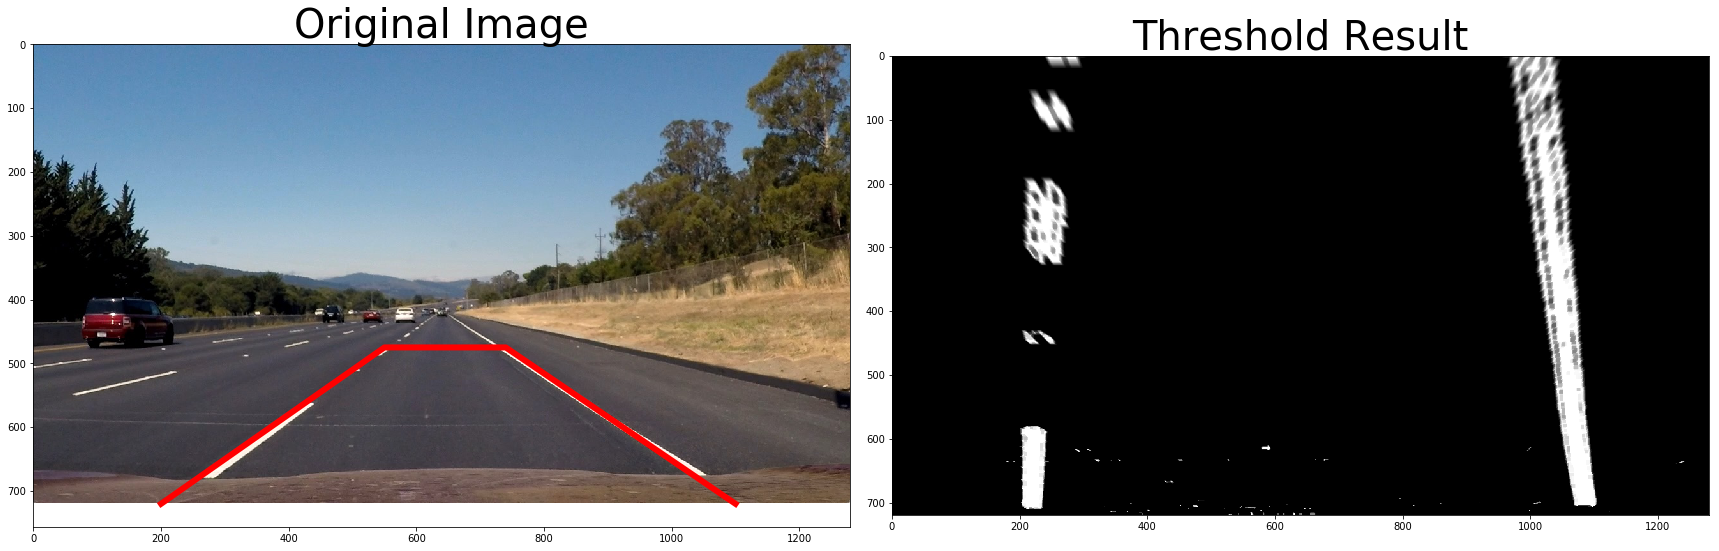

In [7]:
def Perspect(img, src_shape):
    offset = 200
    img_size = (img.shape[1], img.shape[0])
    dst = np.float32([[offset, img_size[1]],[offset, offset], [img_size[0]-offset, offset], 
                    [img_size[0]-offset, img_size[1]]])    
    M = cv2.getPerspectiveTransform(src_shape, dst)
    Minv = cv2.getPerspectiveTransform(dst, src_shape)

    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    return warped, M, Minv

def Closing(img):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    
def FinalProcImage(img):
    proc_img = UndistortImage(img, camera_calib, dist)
    th_image = Threshold(proc_img)

    #apex = [30 + 0.5*img.shape[1], 30 + 0.5*img.shape[0]]
    #vertices = np.array([[(0, img.shape[0]), (img.shape[1], img.shape[0]), 
                          #(apex[0], apex[1])]], dtype=np.int32)
    offset = 200
    #vertices = np.float32([[offset,img.shape[0]],[3*offset,2*offset],
                           #[4*offset,2*offset],[img.shape[1]-offset/2,img.shape[0]]])
    vertices = np.float32([[200,720],[550,475],[740,475],[1100,720]])
    p_img, M, Minv = Perspect(th_image,vertices)
    p_closed_img = Closing(p_img)
    return proc_img,p_img,p_closed_img, M, Minv, vertices

img = cv2.imread(test_images[1])
undistort_img, masked_th_image, closed_image, perspective_mtx, inv_perspective_mtx, trapezium = FinalProcImage(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
#ax1.imshow(closed_image)

X = [trapezium[0,0], trapezium[1,0], trapezium[2,0], trapezium[3,0]]
Y = [trapezium[0,1], trapezium[1,1], trapezium[2,1], trapezium[3,1]]
ax1.plot(X,Y,color = 'red', linewidth=6.0)
ax1.set_title('Original Image', fontsize=40)

#ax2.imshow(masked_th_image)
ax2.imshow(closed_image)
ax2.set_title('Threshold Result', fontsize=40)



(720, 0)

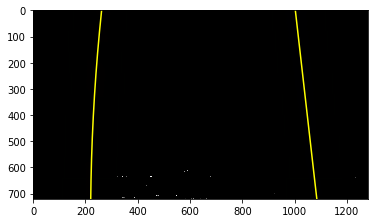

In [8]:
# Line finding
def SlidingWindow(binary_warped):
    binary_warped = binary_warped[:,:,0]
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[360:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return out_img, leftx, lefty, rightx, righty 

out_img, leftx, lefty, rightx, righty  = SlidingWindow(closed_image)

# Generate x and y values for plotting
ploty = np.linspace(0, closed_image.shape[0]-1, closed_image.shape[0] )

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


In [9]:
# Radius of curvature
def CalculateRho(ploty,left_fit, right_fit, leftx, lefty,rightx, righty):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    return left_curverad, right_curverad
    
left_curverad, right_curverad = CalculateRho(ploty,left_fit, right_fit, leftx, lefty, rightx, righty)

In [10]:
# Draw Image
def DrawOverlay(undistort_img, warped, left_fitx, right_fitx, inv_perspective_mtx, left_curve, right_curve):
    # Create an image to draw the lines on
    #warp_zero = np.zeros_like(warped).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    color_warp = np.zeros_like(undistort_img).astype(np.uint8)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inv_perspective_mtx, (undistort_img.shape[1], undistort_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistort_img, 1, newwarp, 0.3, 0)
    str1 = 'Left lane curvature: ' + str(left_curve)
    str2 = 'Right lane curvature: ' + str(right_curve)
    center_dev = (left_fitx[-1] + right_fitx[-1] - undistort_img.shape[1])/2
    str3 = 'Center distance: ' + str(abs(center_dev)* 3.7/700)
    cv2.putText(result, str1, (10,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,155), 2, cv2.LINE_AA)
    cv2.putText(result, str2, (10,80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,155), 2, cv2.LINE_AA)
    cv2.putText(result, str3, (10,120), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,155), 2, cv2.LINE_AA)

    result_img = cv2.cvtColor(result,cv2.COLOR_BGR2RGB);
    #plt.figure(figsize = (24,9))
    #plt.imshow(result_img)
    return result_img

    
    
#result_img = DrawOverlay(img, closed_image, left_fitx, right_fitx, inv_perspective_mtx, left_curverad, right_curverad )

In [11]:
# Combine everything

# At this point we have

# camera_calib        : camera calibration matrix
# dist                : distortion coefficients
# perspective_mtx     : Perspective projection matrix
# inv_perspective_mtx : Inv perspective projection matrix

def Combine(img):
    proc_img = UndistortImage(img, camera_calib, dist)
    th_image = Threshold(proc_img)
    warped_img = cv2.warpPerspective(img, perspective_mtx, (img.shape[1], img.shape[0]))
    closed_img = Closing(warped_img)
    
    out_img, leftx, lefty, rightx, righty  = SlidingWindow(closed_img)

    # Generate x and y values for plotting
    ploty = np.linspace(0, closed_img.shape[0]-1, closed_img.shape[0] )

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_curverad, right_curverad = CalculateRho(ploty,left_fit, right_fit, leftx, lefty, rightx, righty)
    
    return DrawOverlay(img, closed_img, left_fitx, right_fitx, inv_perspective_mtx, left_curverad, right_curverad)
     
    
    # Consider returning line properties for next frame
    
    
img = cv2.imread(test_images[0])
result_img = Combine(img)
    

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'project_output_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(Combine) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_output_video.mp4
[MoviePy] Writing video project_output_video.mp4


100%|█████████▉| 1260/1261 [12:08<00:00,  1.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_video.mp4 

CPU times: user 10min 55s, sys: 2min 18s, total: 13min 13s
Wall time: 12min 10s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))